# Single Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a single harmonic.

In [1]:
import copy
import sys
import os

from isca_tools.thesis.surface_flux_taylor import name_square
from isca_tools.utils.xarray import wrap_with_apply_ufunc, update_dim_slice, transpose_common_dims_like

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, get_density
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import numerical
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, \
    get_temp_extrema_analytic, get_param_dimensionless, phase_coef_conversion
from isca_tools.utils.fourier import fourier_series
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.notebook import tqdm
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots

import jobs.thesis_season.thesis_figs.utils as utils

# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [2]:
ds_base = utils.load_ds(reduced_evap=False)
ds = utils.get_annual_zonal_mean(ds_base)

  0%|          | 0/2 [00:00<?, ?it/s]

## Empirical fitting
Here we find the empirical parameters in the approximation for $\Gamma^{\uparrow} = (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}$ which are completely independent of the number of harmonics used in the solving of the surface energy budget. We just find the parameters $\lambda_0$, $\lambda$, $\lambda_{phase}$, $\lambda_{sq}$, $\Lambda_{cos}$, and $\Lambda_{sin}$ such that:

$$
\Gamma^{\uparrow} \approx \lambda_0 + \frac{1}{2}\lambda_{phase}(T(t-\mathcal{T}/4) - T(t+\mathcal{T}/4)) +
\lambda T(t) + \lambda_{sq} T'^{2}(t) + \Lambda_{cos}\\cos(4\pi t/\mathcal{T}) +
\Lambda_{sin}\sin(4\pi t/\mathcal{T})
$$

where $T' = T(t) - \overline{T}$ is the surface temperature anomaly and $\mathcal{T}$ is the period i.e. one year.

Note that if $\lambda_{sq}$ is not zero, $\lambda$ and $\lambda_0$ will change values from the case where $\lambda_{sq}=0$; a result that is just due to the normal behaviour of ploynomaial fitting i.e., `np.polyfit`.

### Solution for $T$
Given this approximation, we can then seek an analytical expression for the temperature (exact solution if $\lambda_{sq}=0$). This is where our constraint in this notebook of choosing one harmonic comes in. Given this choice, we set $\lambda_{sq} = \Lambda_{cos} = \Lambda_{sin} = 0$ when solving the differential equation as these parameters have no effect on the single harmonic solution.

In [3]:
n_harmonics = xr.DataArray([1, 2, 5], dims="n_harmonics", name='n_harmonics')
# List all fitting methods for this case. Only 1 harmonic in this notebook, so only include linear and linear_phase
fit_method = xr.DataArray(['simulated', 'direct1', 'direct2', 'direct5', 'linear', 'linear_phase'], name='fit_method',
                          dims='fit_method')
fit_method = fit_method.assign_coords(fit_method=fit_method.values)

sw_amp_coefs = {}
sw_fourier_fit = []
temp_anom_fit = [ds.temp_surf]
# temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
for key in n_harmonics.values:
    sw_amp_coefs[key] = utils.get_fourier_fit_xr(ds.time, ds.swdn_sfc, n_harmonics=key, pad_coefs_phase=True)[1]
    # Fit SW fourier with no phase
    sw_fourier_fit.append(utils.fourier_series_xr(ds.time, sw_amp_coefs[key], np.zeros(key + 1), pad_coefs_phase=True))
    temp_anom_fit.append(utils.get_fourier_fit_xr(ds.time, ds.temp_surf, n_harmonics=key, pad_coefs_phase=True)[0])
sw_fourier_fit = xr.concat(sw_fourier_fit, dim=n_harmonics)
sw_fourier_fit = transpose_common_dims_like(sw_fourier_fit, ds.swdn_sfc)

temp_anom_fit = xr.concat(temp_anom_fit,
                          dim=fit_method.sel(fit_method=[key for key in fit_method.values if 'linear' not in key]))
temp_anom_fit = temp_anom_fit - temp_anom_fit.mean(dim='time')
temp_anom_fit = temp_anom_fit.reindex(fit_method=fit_method, fill_value=0)
temp_anom_fit = temp_anom_fit.transpose('fit_method', 'depth', 'lat', 'time')


In [4]:
var = utils.get_fourier_fit_xr(ds.time, ds.swdn_sfc, n_harmonics=2, pad_coefs_phase=True)
var = utils.fourier_series_xr(ds.time, var[1], var[2], pad_coefs_phase=True)
(var - 0 * sw_fourier_fit.sel(n_harmonics=2)).isel(depth=0)
print(
    f"Max error in setting phase coef=0 in 2 harmonic SW Fourier approx: {utils.get_error(var, sw_fourier_fit.sel(n_harmonics=2)).max():.2f}%")

Max error in setting phase coef=0 in 2 harmonic SW Fourier approx: 0.45%


In [5]:
# Initialize Surface upward flux; so can add approximations later
fit_method_flux = xr.DataArray(
    ['simulated', 'linear', 'linear_phase', 'square_phase', 'square_phase+', 'poly10_phase+'],
    name='fit_method', dims='fit_method')
fit_method_flux = fit_method_flux.assign_coords(fit_method=fit_method_flux.values)
surf_flux_up = ds[['flux_lhe', 'flux_t']] * 0
surf_flux_up = surf_flux_up.rename_vars({'flux_lhe': 'lh', 'flux_t': 'sh'})
surf_flux_up['lw'] = (ds.lwup_sfc - ds.lwdn_sfc) * 0
surf_flux_up = surf_flux_up.expand_dims(fit_method=fit_method_flux)
surf_flux_up = surf_flux_up.copy(deep=True)  # so can update variables
surf_flux_up = transpose_common_dims_like(surf_flux_up, temp_anom_fit)

# Whether to use fluxes output from Isca, or those computed from av variables - does not make much difference
# Maybe taylor series stuff is slightly more accurate if compute
method_flux_sim = 'av_var'  # Consider fluxes from av variables rather than av of fluxes
# method_flux_sim = 'av_flux'           # Consider av of fluxes provided

for key in surf_flux_up:
    # Simulated - could possibly use flux computed from variables rather than average from simulation
    # May make more sense to consider fluxes from av variables rather than av of fluxes in the context of solving differential eqn???
    surf_flux_up = update_dim_slice(surf_flux_up, 'fit_method', 'simulated',
                                    utils.get_flux(ds, key, calc=method_flux_sim == 'av_var'), key)
    # Best possible 10 polynomial fit with fourier and phase
    key2 = 'poly10_phase+'
    # Don't save fitting variables, as has deg is much larger so mismatch of dimensions
    var = utils.polyfit_phase_xr(temp_anom_fit.sel(fit_method='simulated'),
                                 surf_flux_up[key].sel(fit_method='simulated'), deg=10,
                                 include_phase='phase' in key2, include_fourier='+' in key2)
    var = utils.polyval_phase_xr(var, temp_anom_fit.sel(fit_method='simulated'))
    surf_flux_up = update_dim_slice(surf_flux_up, 'fit_method', key2, var, key)

surf_flux_up['net'] = surf_flux_up['lh'] + surf_flux_up['sh'] + surf_flux_up['lw']

# Sanity check that smoothed sum of fluxes (flux_net) matches sum of smoothed fluxes (surf_flux_up['net'])
if method_flux_sim != 'av_var':
    var = ds['flux_net'] - surf_flux_up['net'].sel(fit_method='simulated')
    var = float(np.abs((var / np.abs(surf_flux_up['net'].sel(fit_method='simulated')))).fillna(
        0).max() * 100)  # percentage error
    if var > 0.1:
        raise ValueError(
            f"Smoothed sum of fluxes differs sum of smoothed fluxes by more than 0.1% from params fit to sum")

# Initialize parameters used to fit the individual fluxes in surf_flux_up
surf_flux_up_params = (surf_flux_up * 0).sel(fit_method=[key for key in fit_method_flux.values if key
                                                         not in ['simulated', 'poly10_phase+']]).isel(time=0, drop=True)
surf_flux_up_params = surf_flux_up_params.expand_dims({'deg': utils.deg_vals})
surf_flux_up_params = surf_flux_up_params.transpose('fit_method', 'lat', 'depth', 'deg')
surf_flux_up_params = surf_flux_up_params.copy(deep=True)
surf_flux_up_params = transpose_common_dims_like(surf_flux_up_params, temp_anom_fit)

# Compute params for each individual flux for both the linear and linear phase mechanisms
for key in surf_flux_up_params:
    for key2 in surf_flux_up_params.fit_method.values:
        if key2 == 'poly10_phase+':
            continue
        var = utils.polyfit_phase_xr(temp_anom_fit.sel(fit_method='simulated'),
                                     surf_flux_up[key].sel(fit_method='simulated'), deg=2 if 'square' in key2 else 1,
                                     include_phase='phase' in key2, include_fourier='+' in key2)
        surf_flux_up_params = update_dim_slice(surf_flux_up_params, 'fit_method', key2, var, key)
        var = utils.polyval_phase_xr(surf_flux_up_params[key].sel(fit_method=key2),
                                     temp_anom_fit.sel(fit_method='simulated'))
        surf_flux_up = update_dim_slice(surf_flux_up, 'fit_method', key2, var, key)

# Sanity check that the sum of individual params equals the params fit to the sum
var = surf_flux_up_params['lw'] + surf_flux_up_params['lh'] + surf_flux_up_params['sh'] - surf_flux_up_params['net']
var = float(np.abs((var / np.abs(surf_flux_up_params['net']))).fillna(0).max() * 100)  # percentage error
if var > 0.1:
    raise ValueError(f"Sum of params differs by more than 0.1% from params fit to sum")

# Get temp approximations for linear and linear_phase
for key in ['linear', 'linear_phase']:
    var = utils.get_temp_fourier_analytic_xr(ds.time, ds.swdn_sfc, ds.heat_capacity,
                                             surf_flux_up_params['net'].sel(fit_method=key),
                                             n_harmonics=1)[0]
    temp_anom_fit = update_dim_slice(temp_anom_fit, 'fit_method', key, var)

In [6]:
# Error in assuming T^2 dominates squared term
# TODO: should put this in 2nd harmonic notebook using square_phase+ solution.
show_plot = False
var_approx = (temp_anom_fit.sel(fit_method='linear_phase') - temp_anom_fit.sel(fit_method='linear_phase').mean(
    dim='time')) ** 2
var_approx = var_approx - var_approx.mean(dim='time')  # subtract mean value, because approx makes no effect on av term
var_sim = (temp_anom_fit.sel(fit_method='simulated') - temp_anom_fit.sel(fit_method='simulated').mean(dim='time')) ** 2
var_sim = var_sim - var_sim.mean(dim='time')  # subtract mean value, because approx makes no effect on av term
for j in range(ds.depth.size):
    utils.get_error(var_sim, var_approx).isel(depth=j).plot()
    print(f"Lat where above 10% error for depth={ds.depth.values[j]:.0f}: "
          f"{np.round(ds.lat.values[np.where(utils.get_error(var_sim, var_approx).isel(depth=j) > 10)[0]], 1)} degree")
    print(
        f"Max value for depth={ds.depth.values[j]:.0f}: {utils.get_error(var_sim, var_approx).isel(depth=j).max():.0f}%")
plt.gca().axhline(10)
if show_plot:
    plt.show()
else:
    plt.close()

Lat where above 10% error for depth=5: [68.4 71.2 73.9 76.7 79.5 82.3 85.1 87.9] degree
Max value for depth=5: 28%
Lat where above 10% error for depth=20: [71.2 73.9 76.7 79.5 82.3 85.1 87.9] degree
Max value for depth=20: 22%


In [7]:
# Sanity check that lambda_0 and lambda take different values if include lambda_sq or not
print('Example fitting params')
for key in surf_flux_up_params.fit_method.values:
    print(key, np.round(surf_flux_up_params.isel(depth=0, lat=-1).lh.sel(fit_method=key).values, 3))

Example fitting params
linear [ 0.     0.     0.     0.     0.753 12.993]
linear_phase [-9.0000e-03  0.0000e+00  0.0000e+00  0.0000e+00  7.5300e-01  1.2993e+01]
square_phase [-0.009  0.     0.     0.024  0.633  1.627]
square_phase+ [-0.009  1.239  0.122  0.025  0.624  1.328]


## How many harmonics required?
Here we look fit a fourier expansion of a given number of harmonics directly to the temperature and shortwave radiation. It seems that there is a large reduction in error as we go from 1 to 2 harmonics, but not much more is gained by including more than 2 harmonics.

The surface energy budget is
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\uparrow}
$$

It seems that at latitudes less than $60\degree$ that no improvement can be made by increasing the number of harmonics, given the linear approximation of $\Gamma$.

Hence it makes sense to just look at the single harmonic solution but try and improve the approximation of $\Gamma$.

In [8]:
# General plotting info
ax_lims_time = [int(ds.time[0] - 1), int(ds.time[-1] + 1)]
color_approx = {'simulated': 'k', 'direct fit': 'k', 'linear': "C0", '1_harmonic': 'k',
                'lw': "C3", 'lh': "C1", 'sh': "C2", 'linear_phase': "C0"}
color_extrema = {'max': "C3", 'min': "C0"}
linestyle_approx = {'simulated': '-', 'direct fit': ':', 'linear': ':', '1_harmonic': ':', 'linear_phase': '--',
                    'linear_phase_0': '-'}
color_harmonic = {1: 'k', 2: "C1", 5: "C3"}
color_var = {'sum': 'k', 'w_atm': "C2", 'rh': "C0", 'temp_diseqb': "C1",
             'ps': "C5", 'emission_factor': "C4", 't_surf': "C3"}
var_unit_labels = {'w_atm': '[ms$^{-1}$]', 'rh': None, 'temp_diseqb': '[K]', 'ps': '[Pa]', 'emission_factor': None}

In [9]:
# utils.style_map = {
#     # --- change (solid) ---
#     "simulated": ("k", "-", "Simulated"),
#     "direct1": ("k", "-", "Direct"),
#     "direct2": ("C1", "-", "Direct"),
#     "direct5": ("C3", "-", "Direct"),
#     "linear": ("C0", ":", "Linear"),
#     "linear_phase": ("C0", "--", "Linear phase"),
#     "square_phase": ("C1", "-.", "Square phase"),
#     "square_phase+": ("C1", "-", "Square phase+"),
#     "poly10_phase+": ("C2", "-", "Poly10 phase+"),
#     "lw": ("C1", "-", "$\\text{LW}^{\\uparrow}_{\\text{net}}$"),
#     "lh": ("C0", ":", "LH$^{\\uparrow}$"),
#     "sh": ("C2", ":", "SH$^{\\uparrow}$"),
#     "net": ("k", "-", "Sum"),
# }

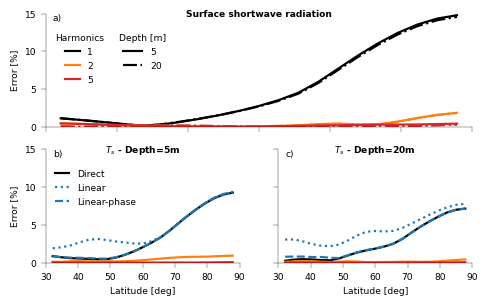

In [10]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, utils.width['two_col'], ar=1.7)
ax = ax.flatten()
ax[1].remove()
ax = np.delete(ax, 1)
l1 = []
l2 = []
for i in n_harmonics.values:
    l1.append(ax[0].plot(ds.lat, utils.get_error(ds.swdn_sfc, sw_fourier_fit.sel(n_harmonics=i)).isel(depth=0),
                         color=utils.style_map[f"direct{i}"][0], label=i)[0])
    l2.append(ax[0].plot(ds.lat, utils.get_error(ds.swdn_sfc, sw_fourier_fit.sel(n_harmonics=i)).isel(depth=1),
                         color=utils.style_map[f"direct{i}"][0], linestyle='-.')[0])
for j in range(ds.depth.size):
    ax[j + 1].set_title(f"$T_s$ - Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.9)
    for i in n_harmonics.values:
        ax[j + 1].plot(ds.lat,
                       utils.get_error(temp_anom_fit.sel(fit_method='simulated'),
                                       temp_anom_fit.sel(fit_method=f"direct{i}")).isel(depth=j),
                       color=utils.style_map[f"direct{i}"][0],
                       label=utils.style_map[f"direct{i}"][2] if i == 1 else None)
    for key in ['linear', 'linear_phase']:
        ax[j + 1].plot(ds.lat,
                       utils.get_error(temp_anom_fit.sel(fit_method='simulated'),
                                       temp_anom_fit.sel(fit_method=key)).isel(depth=j),
                       color=utils.style_map[key][0], label=utils.style_map[key][2],
                       linestyle=utils.style_map[key][1])
        # ax[j+1].plot(ds.lat,
        #    utils.get_error(surf_flux_up.net.sel(fit_method='simulated'), surf_flux_up.net.sel(fit_method=key)).isel(depth=j),
        #    color=utils.style_map[key][0], label=utils.style_map[key][2],
        #              linestyle=utils.style_map[key][1])

update_linewidth(fig, 2)

# Two legends in ax[0]
leg1 = ax[0].legend(handles=l1, handlelength=utils.leg_handlelength, title='Harmonics',
                    loc='upper left', bbox_to_anchor=(0, 0.9))
ax[0].add_artist(leg1)
l2 = [l1[0], l2[0]]
l2[0].set_label(int(ds.depth.values[0]))
l2[1].set_label(int(ds.depth.values[1]))
leg1 = ax[0].legend(handles=l2, title='Depth [m]',
                    loc='upper left', bbox_to_anchor=(0.15, 0.9))

ax[1].legend(loc='upper left', handlelength=utils.leg_handlelength, bbox_to_anchor=(0, 0.9))
ax[0].set_ylabel(utils.label_error)
ax[1].set_ylabel(utils.label_error)
ax[1].set_xlabel(utils.label_lat)
ax[2].set_xlabel(utils.label_lat)
ax[0].set_xlim(utils.ax_lims_lat)

# Make first axis span whole figure
pos = ax[0].get_position()  # Bbox in figure coords [0..1]
pos2 = ax[2].get_position()
ax[0].set_position([pos.x0, pos.y0, pos2.x0 - pos.x0 + pos2.width, pos.height])
label_subplots(fig, ax, pos_y=0)
ax[0].set_title("Surface shortwave radiation", fontweight='bold', y=0.9)
ax[0].set_yticks([0, 5, 10, 15])
ax[0].set_ylim(0, 15)
update_fontsize(fig, 3.8)
plt.show()
# savefig(fig)

## Best Possible Estimate from just single harmonic

Additional powers of temperature in the $\Gamma$ approximation e.g. $\lambda_{sq}T'^2(t)$ would lead to terms of higher order than 1 harmonic in the surface energy budget, thus these cannot be the cause of the discrepancy of the linear $\Gamma$ approximation.

Looking at the $\Gamma$ plot below, there seems to be some hysteresis, which can be explained with a single harmonic. We thus seek an approximation of $\Gamma$ of the following form with three parameters that need to be found:

$\Gamma^{\uparrow} \approx \lambda_0 + \frac{1}{2}\lambda_{phase}(T(t-\mathcal{T}/4) - T(t+\mathcal{T}/4)) +
\lambda T(t)$

The phase delay is 90 days, as this refers to a quarter of the cycle (year has 360 days). This is clear to the eye, once all non phase shifted temperature dependence has been removed.

We do this fitting for each component of $\Gamma$ individually, so we have an idea of where the phase delay is coming from.

Clearly this phase term makes up almost the entire difference to the direct fit.

In [24]:
def phase_coef_conv_xr(coefs, pos_amp=False, take_linear_sign=True, neg_amp=False):
    # Changes intepretation of phase coefficients to a time shift in days.
    # Also converts the deg=0 and deg=1 coefficients to match.
    coefs_out = coefs.copy(deep=True)
    var = list(phase_coef_conversion(coefs.sel(deg='1'), coefs.sel(deg='phase'), pos_amp=pos_amp,
                                     take_linear_sign=take_linear_sign,
                                     neg_amp=neg_amp))
    freq = 1 / ds.time.size
    var[-1] = var[-1] / (2 * np.pi * freq)  # convert to shift in days (positive means phase delay)
    coefs_out = update_dim_slice(coefs_out, 'deg', '1', var[0])
    coefs_out = update_dim_slice(coefs_out, 'deg', 'phase', var[1])
    return coefs_out

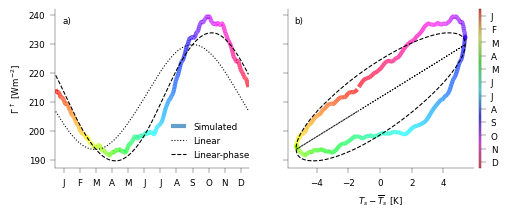

20m
32.1 deg
Normal form {'phase': 2.4, 'cos': 0.0, 'sin': 0.0, '2': 0.0, '1': 3.4, '0': 211.5}
Time form {'phase': 35.6, 'cos': 0.0, 'sin': 0.0, '2': 0.0, '1': 4.2, '0': 211.5}
Dimensionless lambda_ph 0.14330579956491835


In [12]:
plot_lat_ind = 0
plot_depth_ind = -1
fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, utils.width['two_col'])
im = colored_line(ds.time,
                  surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'), c=ds.time,
                  cmap='hsv', ax=ax[0], lw=3, label=utils.style_map['simulated'][2], alpha=0.7)
for key in ['linear', 'linear_phase']:
    ax[0].plot(ds.time, surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method=key), color='k',
               label=utils.style_map[key][2], linestyle=utils.style_map[key][1])
im = colored_line(temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'),
                  surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'), c=ds.time,
                  cmap='hsv', ax=ax[1], lw=3, alpha=0.7)
# im = ax[1].scatter(temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'),
#                    surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'), c=ds.time,
#                    cmap='hsv')
for key in ['linear', 'linear_phase']:
    ax[1].plot(temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'),
               surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method=key), color='k',
               linestyle=utils.style_map[key][1], label=utils.style_map[key][1])

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*utils.month_ticks)
ax[0].set_ylabel(
    '$\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
# ax[0].set_ylabel(
#     '$LW^{\\uparrow}-LW^{\\downarrow}+LH^{\\uparrow}+SH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T_s - \overline{T}_s$ [K]')
# ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
# ax[1].set_ylim(np.floor(gamma['simulated'][plot_lat_ind].min()), np.ceil(gamma['simulated'][plot_lat_ind].max()))
update_linewidth(fig)
ax[0].legend(handlelength=utils.leg_handlelength, loc='lower right', bbox_to_anchor=(1.05, 0))
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*utils.month_ticks)
label_subplots(fig, ax)
update_fontsize(fig)
plt.show()
print(f"{ds.depth.values[plot_depth_ind]:.0f}m")
print(f"{ds.lat.values[plot_lat_ind]:.1f} deg")

# Print interpretation of variables
var = surf_flux_up_params['net'].sel(fit_method='linear_phase').isel(depth=plot_depth_ind, lat=plot_lat_ind)
var_time = phase_coef_conv_xr(var)
print(f"Normal form", {key: np.round(float(var.sel(deg=key)), 1) for key in var.deg.values})
print(f"Time form", {key: np.round(float(var_time.sel(deg=key)), 1) for key in var_time.deg.values})
print(f"Dimensionless lambda_ph",
      float(get_param_dimensionless(var.sel(deg='phase'), heat_capacity=ds.isel(depth=plot_depth_ind).heat_capacity,
                                    n_year_days=ds.time.size)))
# savefig(fig)

In [13]:
def get_extrema_heat_cap_sens(heat_cap, lambda_const=3):
    # Returns the relative sensitivity of amplitude and time of extrema relative to sw of 1st harmonic to 10% change in heat capacity
    # i.e. returns 1/T_1 dT_1/dC (-C/10) and 1/\Delta d\Delta/dC (C/10)
    freq = 1 / (ds.time.size * utils.day_seconds)
    x = 2 * np.pi * freq * heat_cap / lambda_const
    return x ** 2 / (1 + x ** 2) / 10, x / (1 + x ** 2) / 10 / np.arctan(x)


show_plot = False
if show_plot:
    var = np.linspace(ds.heat_capacity.min(), ds.heat_capacity.max(), 31)
    plt.plot(var, get_extrema_heat_cap_sens(var)[0])
var = get_extrema_heat_cap_sens(ds.heat_capacity, surf_flux_up_params.sel(deg='1', fit_method='linear_phase')['net'])
print(f"Extrema amplitude sensitivity for 5m, 10m simulations: {np.round(var[0].mean(dim='lat').values, 3)}")
print(f"Extrema timing sensitivity for 5m, 10m simulations: {np.round(var[1].mean(dim='lat').values, 3)}")

Extrema amplitude sensitivity for 5m, 10m simulations: [0.058 0.096]
Extrema timing sensitivity for 5m, 10m simulations: [0.057 0.014]


### Explicit effect of $\lambda_{phase}$
Below we see that the effect of non-zero $\lambda_{phase}$ is to shift the extrema later and reduce the amplitude.

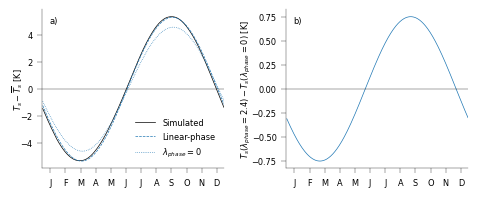

In [14]:
var = surf_flux_up_params['net'].sel(fit_method='linear_phase').isel(lat=plot_lat_ind, depth=plot_depth_ind).copy(
    deep=True)
# var.values[0] = 1.31876951
# var.values[-2] = 4.69879124
phase_param_use = var.values[0]
var.values[0] = 0  # set phase coef to zero
var = utils.get_temp_fourier_analytic_xr(ds.time, ds.swdn_sfc.isel(lat=plot_lat_ind, depth=plot_depth_ind),
                                         ds.heat_capacity.isel(depth=plot_depth_ind),
                                         var, n_harmonics=1)[0]

fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, utils.width['two_col'])
for key in ['simulated', 'linear_phase']:
    ax[0].plot(ds.time, temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method=key),
               color=utils.style_map[key][0], linestyle=utils.style_map[key][1], label=utils.style_map[key][2])
key = 'linear'
ax[0].plot(ds.time, var, color=utils.style_map[key][0], linestyle=utils.style_map[key][1],
           label="$\lambda_{phase}=0$")

ax[1].plot(ds.time, temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='linear_phase') - var,
           color="C0")

ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*utils.month_ticks)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$T_s - \overline{T}_s$ [K]', labelpad=-3)
ax[0].legend()
# var = surf_flux_up_params
ax[1].set_ylabel(
    f'$T_s(\lambda_{"{phase}"}={phase_param_use:.2g}) - T_s(\lambda_{"{phase}"}= 0)$ [K]', labelpad=-1)
plt.subplots_adjust(wspace=0.34)
label_subplots(fig, ax)
update_fontsize(fig)
plt.show()
# savefig(fig)

### Extrema
Show that 1 harmonic cannot capture differing minima and maxima. Also, that linear phase basically perfectly matches the direct fit; much better than linear anyway.

In [15]:
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size / 2)])}

# Initialize ds_extrema
ds_extrema = xr.Dataset({key: 0 * sw_fourier_fit.isel(time=0, n_harmonics=0).expand_dims({'fit_method': fit_method})
                         for key in ['time_min', 'time_max', 'amp_min', 'amp_max']})

# Add extrema diagnostics to simulated and approximations so far
for key in ds_extrema.fit_method.values:
    ds_extrema = utils.update_ds_extrema(ds_extrema, ds.time, temp_anom_fit.sel(fit_method=key), key)

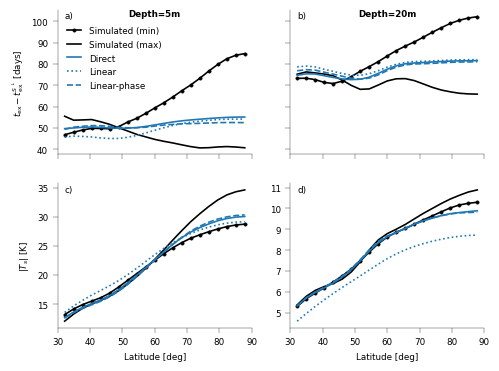

In [16]:
fig, ax = plt.subplots(2, 2, sharex=True)
fig_resize(fig, utils.width['two_col'])
for j in range(ds.depth.size):
    ax[0, j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.9)
    ax[1, j].set_xlabel(utils.label_lat)
    for key2 in ['simulated', 'direct1', 'linear', 'linear_phase']:
        for key in time_extrema_sw:
            if (key == 'min') and (key2 != 'simulated'):
                continue
            color_use = utils.style_map['linear'][0] if 'direct' in key2 else utils.style_map[key2][0]
            if key2 == 'simulated':
                label_use = f'Simulated ({key})'
            else:
                label_use = utils.style_map[key2][2]
            linestyle_use = utils.style_map[key2][1]
            ax[0, j].plot(ds.lat, ds_extrema[f"time_{key}"].isel(depth=j).sel(fit_method=key2) - time_extrema_sw[key],
                          color=color_use, linestyle=linestyle_use, label=label_use,
                          marker='.' if key == 'min' else None,
                          markersize=5)
            ax[1, j].plot(ds.lat, ds_extrema[f"amp_{key}"].isel(depth=j).sel(fit_method=key2),
                          color=color_use, linestyle=linestyle_use, label=label_use,
                          marker='.' if key == 'min' else None,
                          markersize=5)
ax[0, 0].set_ylabel("$t_{\\text{ex}} - t^{S^{\\downarrow}}_{\\text{ex}}$ [days]")
ax[1, 0].set_ylabel(f"$|T_s|$ [K]")
update_linewidth(fig, 1.5)
ax[0, 1].sharey(ax[0, 0])
ax[0, 1].tick_params(axis='y', labelleft=False)
ax[0, 0].legend(handlelength=utils.leg_handlelength, loc='upper left', bbox_to_anchor=(0, 0.95))
ax[0, 0].set_xlim(utils.ax_lims_lat)
label_subplots(fig, ax.flatten(), pos_y=-1)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Breakdown of $\Gamma$
Below we plot how well we can approximate each contribution to $\Gamma$ using the various levels of the hierarchy. This is completely independent of our analytic solution for $T_s$. We make no assumptions about solar radiation or number of harmonics here.

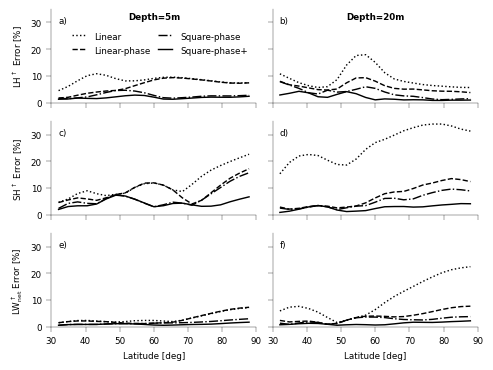

In [17]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
fig_resize(fig, utils.width['two_col'], ar=2)
for j in range(ds.depth.size):
    ax[0, j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.8)
    ax[-1, j].set_xlabel(utils.label_lat)
    for key2 in ['linear', 'linear_phase', 'square_phase', 'square_phase+']:
        for i, key in enumerate(surf_flux_up):
            if key == 'net':
                continue
            if j == 0 and key2 == 'linear':
                ax[i, j].set_ylabel(f"{utils.style_map[key][2]} {utils.label_error}")
            ax[i, j].plot(ds.lat, utils.get_error(surf_flux_up[key].sel(fit_method='simulated'),
                                                  surf_flux_up[key].sel(fit_method=key2)).isel(depth=j),
                          color='k',
                          linestyle=utils.style_map[key2][1], label=utils.style_map[key2][2])
update_linewidth(fig, 1.3)
ax[0, 0].legend(handlelength=utils.leg_handlelength, ncol=2,
                columnspacing=0.7, loc='upper right', bbox_to_anchor=(1, 0.85))
label_subplots(fig, ax.flatten())
update_fontsize(fig)
ax[0, 0].set_xlim(utils.ax_lims_lat)
ax[0, 0].set_ylim(0, 35)
plt.subplots_adjust(wspace=0.08)
plt.show()
# savefig(fig)

### Empirical parameters
How the empirical parameters that affect the 1 harmonic approximation vary as a function of latitude.

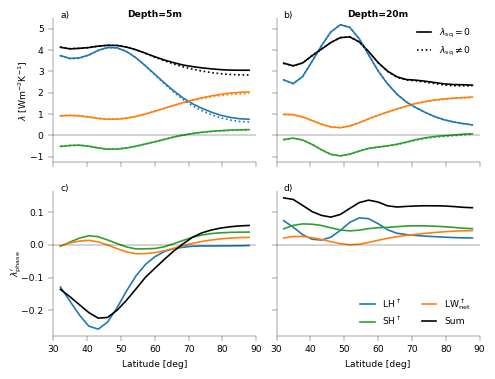

In [18]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
fig_resize(fig, utils.width['two_col'])
for j in range(ds.depth.size):
    ax[0, j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.95)
    ax[1, j].set_xlabel(utils.label_lat)
    for key2 in ['linear_phase', 'square_phase+']:
        for key in surf_flux_up_params:
            color_use = utils.style_map['linear'][0] if 'direct' in key2 else utils.style_map[key2][0]
            if key2 == 'simulated':
                label_use = f'Simulated ({key})'
            else:
                label_use = utils.style_map[key2][2]
            linestyle_use = utils.style_map[key2][1]
            ax[0, j].plot(ds.lat, surf_flux_up_params[key].isel(depth=j).sel(fit_method=key2, deg='1'),
                          color=utils.style_map[key][0], linestyle=':' if 'square' in key2 else None,
                          label=(
                              "$\lambda_{\\text{sq}}=0$" if 'linear' in key2 else "$\lambda_{\\text{sq}}\\neq0$") if key == 'net' else None)
            if key2 == 'linear_phase':
                # This param always the same, so only plot for linear case
                # Use dimensionless form as for ease of interpretation
                lambda_phase_dim = get_param_dimensionless(
                    surf_flux_up_params[key].isel(depth=j).sel(fit_method=key2, deg='phase'),
                    heat_capacity=ds.heat_capacity.isel(depth=j), n_year_days=ds.time.size)
                ax[1, j].plot(ds.lat, lambda_phase_dim,
                              color=utils.style_map[key][0], linestyle=':' if 'square' in key2 else None,
                              label=utils.style_map[key][2])
update_linewidth(fig, 1.5)
ax[0, 1].legend(handlelength=utils.leg_handlelength, loc='upper right')
ax[1, 1].legend(handlelength=utils.leg_handlelength, ncol=2, loc='lower right')
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=5)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(utils.ax_lims_lat)
ax[0, 0].set_ylabel("$\lambda$ [Wm$^{-2}$K$^{-1}$]", labelpad=0)
ax[1, 0].set_ylabel("$\lambda_{\\text{phase}}'$", labelpad=-2)
plt.subplots_adjust(wspace=0.1)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Link to Taylor Series

Now that we see that the emprical fitting is decent, we would like to relate it to the taylor series decomposition of the effect of each variable on each flux.

### Empirical fitting of variables
We do this by fitting the same empirical fitting to each of the variables above (for non linear and square terms, we fit a separate fitting, don't compute from the individual fitting variables). Then we multiply these empirical variables with the taylor series coefficients to obtain the approximate contribution from each variable.

We first show the error in the empirical fitting of the variables in the decomposition, which is pretty small except at high latitudes.

In [19]:
# We are only considering one harmonic, so lambda_cos, lambda_sin, lambda_sq don't come into things here
# But we fit variables with them anyway because lambda and lambda_phase change if included
# Difference is very small though
ds_ref, var_params, _, var_fit_error = utils.get_empirical_var_fit(ds[utils.style_map_var.keys()], deg=2,
                                                                   include_fourier=True,
                                                                   error_norm_dim='lat')
# Add temp_surf for ease of finding surf_flux_up_param_cont
for i, key in enumerate(['temp_surf', name_square('temp_surf')]):
    var_params[key] = var_params['w_atm'] * 0
    # set temp_surf = 1 x T and nl_temp_surf_square = 1 x T^2
    var_params = update_dim_slice(var_params, 'deg', str(i + 1), 1, key)

ds_ref.attrs = ds.attrs
for key in ['sigma_atm', 'odp_surf', 'evap_prefactor']:
    ds_ref[key] = ds[key]

flux_gamma = {key: utils.get_flux_sensitivity(ds_ref, key) for key in ['lh', 'sh', 'lw']}

surf_flux_up_param_cont = {}
for key in flux_gamma:
    surf_flux_up_param_cont[key] = {}
    for key2 in flux_gamma[key]:
        if key2 not in var_params:
            continue
        surf_flux_up_param_cont[key][key2] = flux_gamma[key][key2] * var_params[key2]
    surf_flux_up_param_cont[key] = xr.Dataset(surf_flux_up_param_cont[key])
    surf_flux_up_param_cont[key]['sum'] = surf_flux_up_param_cont[key].to_array().sum(dim='variable')

# Sum up contributions from individual fluxes
surf_flux_up_param_cont['net'] = surf_flux_up_param_cont[list(flux_gamma.keys())[0]].copy(deep=True)
for key in list(flux_gamma.keys())[1:]:
    for key2 in surf_flux_up_param_cont[key]:
        if key2 in surf_flux_up_param_cont['net']:
            surf_flux_up_param_cont['net'][key2] += surf_flux_up_param_cont[key][key2]
        else:
            surf_flux_up_param_cont['net'][key2] = surf_flux_up_param_cont[key][key2]

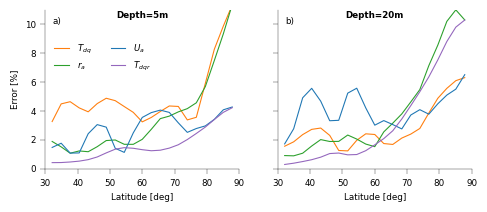

In [20]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey='row')
fig_resize(fig, utils.width['two_col'])
for j in range(ds.depth.size):
    ax[j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.9)
    ax[j].set_xlabel(utils.label_lat)
    for key in utils.style_map_var.keys():
        if key in ['temp_surf', 'p_surf']:
            # Ignore pressure as not important here
            continue
        ax[j].plot(ds.lat, var_fit_error.isel(depth=j)[key], color=utils.style_map_var[key][0],
                   label=utils.style_map_var[key][2] if j == 0 else None)
update_linewidth(fig)
ax[0].legend(ncol=2, handlelength=utils.leg_handlelength, loc='upper left', bbox_to_anchor=(0, 0.85))
ax[0].set_ylabel(utils.label_error)
label_subplots(fig, ax)
update_fontsize(fig)
ax[0].set_xlim(utils.ax_lims_lat)
ax[0].set_ylim(0, 11)
plt.show()

### Contribution of each variable to $\lambda$ and $\lambda_{phase}$
We can now give the contribution of each variable to each flux. We then combine this over all fluxes to give the net contribution of each variable. It is pretty clear which flux each variable affects. RH is latent heat, the direct $T_s$ is latent heat, the wind is mainly latent heat, the $T_{dq}$ is mainly sensible heat.

You can compare this to the individual flux contributions above.

In [21]:

def get_param_dimensionless_wrap(var, deg, heat_capacity,
                                 n_year_days=ds.time.size, no_norm=False):
    # Wrapper to compute dimensionless form of empirical fitting variable from var which contains all deg
    var_use = var.sel(deg=deg)
    if no_norm:
        return var_use
    else:
        if deg == '1':
            return var_use  # keep dimensionless for lambda
        elif deg == 'phase':
            var_use = get_param_dimensionless(var_use, heat_capacity=heat_capacity, n_year_days=n_year_days)
        return var_use

# norm_factor_deg2 = 0.02  # Should probably make mean over both simulations of absolute value of direct empirical fit
# def get_param_dimensionless_wrap(var, deg, heat_capacity, sw_amp2, norm_factor_deg2=norm_factor_deg2,
#                                  n_year_days=ds.time.size, no_norm=True):
#     # Wrapper to compute dimensionless form of empirical fitting variable from var which contains all deg
#     var_use = var.sel(deg=deg)
#     if no_norm:
#         return var_use
#     else:
#         if deg == '1':
#             return var_use  # keep dimensionless for lambda
#         elif deg == '2':
#             # Specify normalization for deg=2 as get singularity
#             var_use = var_use / norm_factor_deg2
#         elif deg == 'phase':
#             var_use = get_param_dimensionless(var_use, heat_capacity=heat_capacity, n_year_days=n_year_days)
#         elif deg in ['cos', 'sin']:
#             var_use = get_param_dimensionless(var_use, sw_fourier_amp2=sw_amp2)
#         return var_use

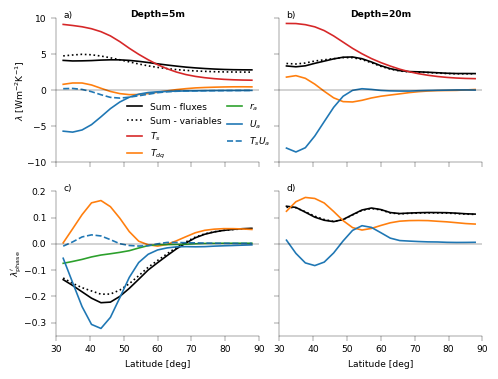

In [22]:
#TODO: maybe make empirical solid and sum dotted - compare with other similar figs in thesis
key = 'net'  # can change this to see individual fluxes
key2 = 'square_phase+'  # results for lambda are slightly different if don't include square term
if key in ['net', 'lh']:
    plot_thresh = {'1': 1, 'phase': 0.03}
else:
    plot_thresh = {'1': 0.2, 'phase': 0.01}
style_map_var = {**utils.style_map_var, **utils.style_map_var_nl}

fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
fig_resize(fig, utils.width['two_col'])
for j in range(ds.depth.size):
    ax[0, j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.95)
    ax[1, j].set_xlabel(utils.label_lat)
    for i, key3 in enumerate(['1', 'phase']):
        var = get_param_dimensionless_wrap(surf_flux_up_params[key].sel(fit_method=key2), key3, ds.heat_capacity).isel(
            depth=j)
        ax[i, j].plot(ds.lat, var, color='k', label='Sum - fluxes')
        var = get_param_dimensionless_wrap(surf_flux_up_param_cont[key]['sum'], key3, ds.heat_capacity).isel(depth=j)
        ax[i, j].plot(ds.lat, var, color='k', label='Sum - variables', linestyle=':')
        for key4 in surf_flux_up_param_cont[key]:
            if key4 == 'sum':
                continue
            var = get_param_dimensionless_wrap(surf_flux_up_param_cont[key][key4], key3, ds.heat_capacity).isel(depth=j)
            if np.abs(var).max() > plot_thresh[key3]:
                ax[i, j].plot(ds.lat, var, label=style_map_var[key4][2], linestyle=style_map_var[key4][1],
                              color=style_map_var[key4][0])
            if (key4 == 'rh_atm') and (j + i == 0):
                # So add rh to legend
                ax[0, 0].plot(-10, 0, label=style_map_var[key4][2], linestyle=style_map_var[key4][1],
                              color=style_map_var[key4][0])

update_linewidth(fig, 1.5)
ax[0, 0].legend(handlelength=utils.leg_handlelength, ncol=2, loc='lower right', bbox_to_anchor=(1.1, -0.05),
                columnspacing=0.6)
# ax[1, 1].legend(handlelength=utils.leg_handlelength, ncol=2)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=5)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(utils.ax_lims_lat)
ax[0, 0].set_ylabel("$\lambda$ [Wm$^{-2}$K$^{-1}$]", labelpad=0)
ax[1, 0].set_ylabel("$\lambda_{\\text{phase}}'$", labelpad=0)
if key in ['net', 'lh']:
    ax[0, 0].set_ylim(-10, 10)
    ax[1, 0].set_ylim(-0.35, 0.2)
plt.subplots_adjust(wspace=0.1)
update_fontsize(fig)
plt.show()
# savefig(fig)

### Time Delay interpretation of individual variables

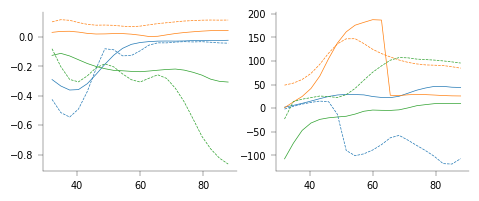

In [98]:
# Play around with phase delay of variables
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)
fig_resize(fig, utils.width['two_col'])

for i in range(ds.depth.size):
    # Force sign of lambda_mod to match that of usual sign of lambda and physical intuition
    # I.e., windier when colder
    key = 'w_atm'
    var = phase_coef_conv_xr(var_params[key], neg_amp=True, take_linear_sign=False).sel(deg=['1', 'phase'])
    ax[0].plot(ds.lat, var.isel(deg=0, depth=i), label=style_map_var[key][2], linestyle=[None, '--'][i],
               color=style_map_var[key][0])
    ax[1].plot(ds.lat, var.isel(deg=1, depth=i), label=style_map_var[key][2], linestyle=[None, '--'][i],
               color=style_map_var[key][0])
    key = 'temp_diseqb'
    var = phase_coef_conv_xr(var_params[key], pos_amp=True, take_linear_sign=False).sel(deg=['1', 'phase'])
    # for j in range(ds.lat.size):
    #     if ds.lat[j]>50:
    #         if var.values[0, j, 1] < -100:
    #             var.values[0, j, 0] *= -1
    #             var.values[0, j, 1] += 360
    ax[0].plot(ds.lat, var.isel(deg=0, depth=i), label=style_map_var[key][2], linestyle=[None, '--'][i],
               color=style_map_var[key][0])
    ax[1].plot(ds.lat, var.isel(deg=1, depth=i)%360, label=style_map_var[key][2], linestyle=[None, '--'][i],
               color=style_map_var[key][0])
    key = 'rh_atm'
    var = phase_coef_conv_xr(var_params[key], neg_amp=True, take_linear_sign=False).sel(deg=['1', 'phase'])
    ax[0].plot(ds.lat, var.isel(deg=0, depth=i)*100, label=style_map_var[key][2], linestyle=[None, '--'][i],
               color=style_map_var[key][0])
    ax[1].plot(ds.lat, var.isel(deg=1, depth=i), label=style_map_var[key][2], linestyle=[None, '--'][i],
               color=style_map_var[key][0])
# savefig(fig)
# Note y-axis of ax[0] has different units for each variable

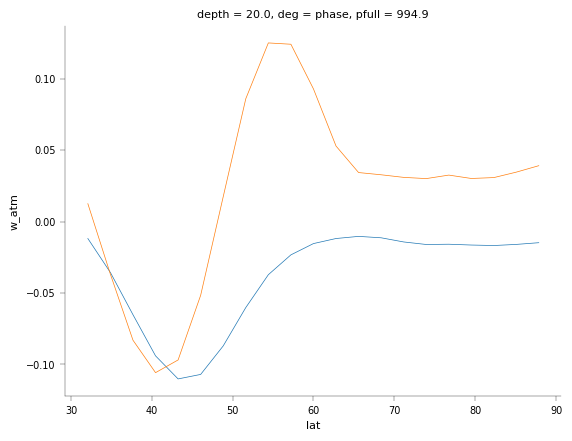

In [95]:
key = 'w_atm'
var = var_params[key].sel(deg=['1', 'phase'])
var.sel(deg='phase').isel(depth=0).plot()
var.sel(deg='phase').isel(depth=1).plot()